In [26]:
# model構築の準備
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D,Input,Dropout,Activation
from keras.applications.mobilenetv2 import MobileNetV2
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import CSVLogger,EarlyStopping
import numpy as np
from keras import backend as K
from keras.engine.topology import Layer
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array, array_to_img
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Arcfacelayerの実行
%run arcface.py 

In [3]:
def create_mobilenet_with_arcface(n_categories, file_path=None):
    base_model=MobileNetV2(input_shape=(224,224,3),
                       weights='imagenet',
                       include_top=False)
    
    
    #add new layers instead of FC networks
    x = base_model.output
    yinput = Input(shape=(n_categories,))
    # stock hidden model
    hidden = GlobalAveragePooling2D()(x)
    # stock Feature extraction
    #x = Dropout(0.5)(hidden)
    x = Arcfacelayer(5, 30, 0.05)([hidden,yinput])
    #x = Dense(1024,activation='relu')(x)
    prediction = Activation('softmax')(x)
    model = Model(inputs=[base_model.input,yinput],outputs=prediction)
    
    if file_path:
        model.load_weights(file_path)
        print('weightは{}'.format(file_path))
    
    return model

In [4]:
def create_predict_model(n_categories, file_path):
    arcface_model = create_mobilenet_with_arcface(n_categories, file_path)
    predict_model = Model(arcface_model.get_layer(index=0).input, arcface_model.get_layer(index=-4).output)
    predict_model.summary()
    return predict_model

In [7]:
# learn model
model = create_mobilenet_with_arcface(5)# 重みloadしない
model.summary()

In [8]:
# folderをtrainとtestに分ける
%run gazo_sprit_many_class.py

In [9]:
class train_Generator_xandy(object): # rule1
    def __init__(self):
        datagen = ImageDataGenerator(
                             vertical_flip = False,
                             width_shift_range = 0.1,
                             height_shift_range = 0.1,
                             rescale=1.0/255.,
                             zoom_range=0.2,  
                             fill_mode = "constant", 
                             cval=0)
        train_generator=datagen.flow_from_directory(
          train_dir,
          target_size=(224,224),
          batch_size=25,
          class_mode='categorical',
          shuffle=True)
        
        self.gene = train_generator
        
    def __iter__(self):
    # __next__()はselfが実装してるのでそのままselfを返す
        return self
    
    def __next__(self): 
        X, Y = self.gene.next()
        return [X,Y], Y
    
    
class val_Generator_xandy(object):
    def __init__(self):
        validation_datagen=ImageDataGenerator(rescale=1.0/255.)
        
        validation_generator=validation_datagen.flow_from_directory(
            validation_dir,
            target_size=(224,224),
            batch_size=25,
            class_mode='categorical',
            shuffle=True)
            
        self.gene = validation_generator
        
    def __iter__(self):
    # __next__()はselfが実装してるのでそのままselfを返す
        return self
            
    def __next__(self): 
        X, Y = self.gene.next()
        return [X,Y], Y

train_dir = './zidolegi_data/train'
validation_dir = './zidolegi_data/validation'
train_gene = train_Generator_xandy()
val_gane = val_Generator_xandy()


Found 769 images belonging to 5 classes.
Found 165 images belonging to 5 classes.


In [11]:
# layerを徐々に解凍しながら学習する
from keras import callbacks

touketulayerlists = [
   model.layers.index(model.get_layer("arcfacelayer_1")),
   model.layers.index(model.get_layer("block_16_expand")),
   model.layers.index(model.get_layer("block_15_expand")),
   model.layers.index(model.get_layer("block_14_expand")),
   model.layers.index(model.get_layer("block_13_expand")),
   model.layers.index(model.get_layer("block_12_expand")),
   model.layers.index(model.get_layer("block_11_expand")),
   model.layers.index(model.get_layer("block_10_expand")),
   model.layers.index(model.get_layer("block_9_expand")),
   model.layers.index(model.get_layer("block_8_expand")),
   model.layers.index(model.get_layer("block_7_expand")),
   model.layers.index(model.get_layer("block_6_expand"))
]

maenosavepath = None
for touketu in touketulayerlists:
    print('touketu{}'.format(touketu))
    
    modelsavepath = "zidolege_model/m02_fine{}kara_weights".format(touketu)
    if maenosavepath:
        model.load_weights(maenosavepath)
        
    maenosavepath = modelsavepath
    #凍結
    for layer in model.layers[:touketu]:
        layer.trainable=False
    for layer in model.layers[touketu:]:
        layer.trainable=True
        
    model.compile(optimizer=Adam(lr=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    callbacks_list = [
        #バリデーションlossが改善したらモデルをsave
        callbacks.ModelCheckpoint(
        filepath=modelsavepath,
        monitor="val_loss",
        save_weights_only=True,
        save_best_only=True),
        
        #バリデーションlossが改善しなくなったら学習率を変更する
        callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.8,
            patience=5,
            verbose=1)]
    
    model.fit_generator(train_gene, steps_per_epoch=80, epochs=30, validation_steps=20, validation_data=val_gane, callbacks=callbacks_list)

touketu157
Epoch 1/30


KeyboardInterrupt: 

In [63]:
def test_acc(model, test_dir, hold_dir, classes, thresh=0, sample=100):
    """
    テスト用
    model: 特徴抽出用モデル
    X: array
    test_dir: str 画像入ってるフォルダ
    hold_dir:str 登録データのフォルダ　ファイル名はclass名.jpgにしてください
    classes:　フォルダ名のリスト 
    """
    correct = 0
    hold_vector = get_hold_vector(model, classes, hold_dir)
    
    test_datagen=ImageDataGenerator(rescale=1.0/255.)
    test_generator=test_datagen.flow_from_directory(
            test_dir,
            target_size=(224,224),
            batch_size=1,
            class_mode='categorical',
            classes=classes)
    
    for i in range(sample):
        X, Y = test_generator.next()
        Y = np.argmax(Y, axis=1)
        predict_vector = model.predict(X)
        index = judgment(predict_vector,hold_vector, thresh)
        label_index = index // 4
        if Y == label_index:
            correct += 1
        
        print('label_index{}'.format(label_index))
        print('Y{}'.format(Y))
    acc = correct / sample
    print("acc: {}".format(acc))
    return acc

def cosine_similarity(x1, x2):
    if x1.ndim == 1:
        x1 = x1[np.newaxis]
    if x2.ndim == 1:
        x2 = x2[np.newaxis]
    x1_norm = np.linalg.norm(x1, axis=1)
    x2_norm = np.linalg.norm(x2, axis=1)
    cosine_sim = np.dot(x1, x2.T)/(x1_norm*x2_norm+1e-10)
    return cosine_sim

# new画像のcos類似度を比較して一番値が高いindexを取り出しその値が閾値を超えるならindexを閾値以下ならをNoneを返す

def judgment(predict_vector, hold_vector, thresh):
    """
    predict_vector : shape(1,1028)
    hold_vector : shape(5, 1028)
    """
    cos_similarity = cosine_similarity(predict_vector, hold_vector) # shape(1, 5)
    print('cos_similarity{}'.format(cos_similarity[0]))
    # 最も値が高いindexを取得
    high_index = np.argmax(cos_similarity[0]) # int

    # cos類似度が閾値を超えるか
    if cos_similarity[0, high_index] > thresh:
        #print('high_index{}'.format(high_index))
        return high_index

    else:
        return None

def get_hold_vector(model, classes, hold_dir):
    """
    classes: クラス名のリスト　イメージの名前はこのリスト名にしてください
    hold_dir: str イメージが入ったフォルダpath
    """
    img_array = np.empty((0, 224,224,3))

    for clas in classes:
        for i in range(4):
            imagepath = os.path.join(hold_dir, clas + str(i) +".jpg")
            img = load_img(imagepath, target_size=(224,224))
            array = img_to_array(img).reshape(1, 224, 224, 3)
            img_array = np.vstack((img_array, array))
        
    img_array = img_array/255.0
    hold_vector = model.predict(img_array)

    return hold_vector

In [16]:
# hold_vector作成用の辞書
drink_dict = {"calpis":5, "ilohas_peach":4, "mitsuya":3, "ilohas_normal":2, "pocari":1}
# hold_vectorをファイルに保存

import pickle
def pickel_hold_vector(hold_vector, classes, num_image=4):
    #ファイルに書き込み
    name_list = []
    for clas in classes:
        name_list += ["zidolegi_data2/feature/{}_{}_feature.dump".format(drink_dict[clas], i) for i in range(num_image)]
        
    for vec, name in zip(hold_vector, name_list):
        with open(name , 'wb') as f:
            pickle.dump(vec, f)


In [18]:
hold_dir = "zidolegi_data/hold"
test_dir = "zidolegi_data/test"
classes = os.listdir(test_dir)
hold_vector = get_hold_vector(load_model, classes, hold_dir)
pickel_hold_vector(hold_vector, classes)

In [37]:
# create_predict_model
file_path = "./zidolege_model/m005_fine91kara_weights" # 保存した中で良い重みをload
model = create_predict_model(5, file_path)

weightは./zidolege_model/m005_fine91kara_weights
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_11[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_____________________________________________________________

In [44]:
# predict
test_acc(model, test_dir, hold_dir, classes, sample=150)

Found 145 images belonging to 5 classes.
cos_similarity[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.99999964 0.9999967  0.9999974  0.9999958  0.         0.
 0.         0.        ]
label_index3
Y[3]
cos_similarity[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.9999976 0.9999992
 0.9999998 0.9999989 0.        0.        0.        0.       ]
label_index3
Y[3]
cos_similarity[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.99999756 0.9999973  0.99999857 0.9999977  0.         0.
 0.         0.        ]
label_index3
Y[3]
cos_similarity[0.9999938  0.999998   0.99999654 0.99999523 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
label_index0
Y[0]
cos_similarity[0.00000000e+00 0

 5.3507510e-09 0.0000000e+00 0.0000000e+00 1.3161955e-08 0.0000000e+00]
label_index1
Y[1]
cos_similarity[0.99999636 0.9999993  0.99999857 0.999997   0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
label_index0
Y[0]
cos_similarity[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 2.0990639e-07 9.9998373e-01 9.9999905e-01
 9.9999738e-01 9.9993795e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00
 9.8063971e-08 0.0000000e+00 0.0000000e+00 2.4122104e-07 0.0000000e+00]
label_index2
Y[2]
cos_similarity[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 7.8448545e-07 9.9998635e-01 9.9998999e-01
 9.9998796e-01 9.9994844e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00
 3.6649561e-07 0.0000000e+00 0.0000000e+00 9.0151809e-07 0.0000000e+00]
label_index2
Y[2]
cos_similarity[0.0000000e+00 0.0000000e+00 

 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
label_index1
Y[1]
cos_similarity[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 6.7404284e-07 9.9998677e-01 9.9999267e-01
 9.9999088e-01 9.9994725e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00
 3.1489904e-07 0.0000000e+00 0.0000000e+00 7.7459919e-07 0.0000000e+00]
label_index2
Y[2]
cos_similarity[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.99999905 0.9999997
 0.99999815 0.99999946]
label_index4
Y[4]
cos_similarity[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 9.9999887e-01
 9.9999923e-01 9.9999917e-01 9.9999744e-01 1.3309086e-05 0.0000000e+00
 0.0000000e+00 8.4963962e-03 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
label_index1
Y[1]
cos_similarity[0.0000000e+00 0.0000000e+00 0.0

 1.9462041e-07 0.0000000e+00 0.0000000e+00 4.7873374e-07 0.0000000e+00]
label_index2
Y[2]
cos_similarity[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 9.9999958e-01
 9.9999982e-01 9.9999982e-01 9.9999797e-01 1.3318078e-05 0.0000000e+00
 0.0000000e+00 8.4965359e-03 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
label_index1
Y[1]
cos_similarity[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.9999998 0.9999991 0.9999982 0.9999997]
label_index4
Y[4]
cos_similarity[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 9.9999946e-01
 9.9999970e-01 9.9999970e-01 9.9999791e-01 1.3310976e-05 0.0000000e+00
 0.0000000e+00 8.4963683e-03 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
label_index1
Y[1]
cos_similarity[0.0000000e+00 0.0000000e+00 0.0000000e+

 0.         0.        ]
label_index3
Y[3]
cos_similarity[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.99999905 0.9999997
 0.99999815 0.99999946]
label_index4
Y[4]
cos_similarity[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.99999964 0.99999845
 0.99999774 0.9999995 ]
label_index4
Y[4]
cos_similarity[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.9999997  0.99999887
 0.9999984  0.99999964]
label_index4
Y[4]
cos_similarity[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.38302195e-09 0.00000000e+00 0.00000000e+00 1.02564805e-07
 9.99995887e-01 9.99999464e-01 9.999994

1.0

In [67]:
# コサイン類似度が高いラベルを返す関数
def classify_image(image_vector, FEATURE_FILE_PATH):
    #read feature_vector from pickle
    files = []
    for x in os.listdir(FEATURE_FILE_PATH):
        if os.path.isfile(FEATURE_FILE_PATH + x):
            files.append(x)

    label = None
    max_cos_similarity = 0
    for i, file in enumerate(files):
        file_path = FEATURE_FILE_PATH + file
        #print("debug {} {}".format(i, file_path))
        with open(file_path, 'rb') as f:
            reference_vector = pickle.load(f)

        cos_similarity = cosine_similarity(image_vector, reference_vector)
        #print("Prediction cos_similarity:{} file:{}".format(cos_similarity, file))
        if max_cos_similarity < cos_similarity:
            max_cos_similarity = cos_similarity
            tmp = file.split("_")
            label = tmp[0]

    return label

Found 145 images belonging to 5 classes.
Found 145 images belonging to 5 classes.
Found 145 images belonging to 5 classes.
Found 145 images belonging to 5 classes.
Found 145 images belonging to 5 classes.
Found 145 images belonging to 5 classes.
Found 145 images belonging to 5 classes.
Found 145 images belonging to 5 classes.
Found 145 images belonging to 5 classes.
Found 145 images belonging to 5 classes.
Found 145 images belonging to 5 classes.
Found 145 images belonging to 5 classes.
Found 145 images belonging to 5 classes.
Found 145 images belonging to 5 classes.
Found 145 images belonging to 5 classes.
Found 145 images belonging to 5 classes.
Found 145 images belonging to 5 classes.
Found 145 images belonging to 5 classes.
Found 145 images belonging to 5 classes.
Found 145 images belonging to 5 classes.
Found 145 images belonging to 5 classes.
Found 145 images belonging to 5 classes.
Found 145 images belonging to 5 classes.
Found 145 images belonging to 5 classes.
Found 145 images

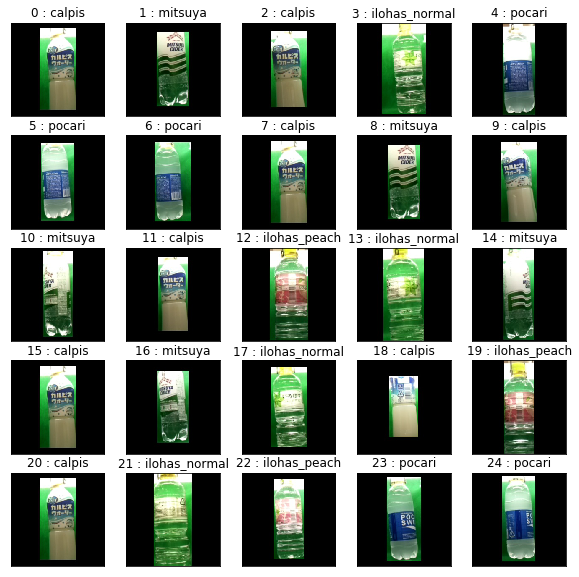

In [71]:
# 画像の表示
label_dict = {"5":"calpis", "4":"ilohas_peach", "3":"mitsuya", "2":"ilohas_normal", "1":"pocari"}
FEATURE_FILE_PATH = "zidolegi_data/feature/"
plt.figure(figsize=(10,10))
for i in range(25):
    test_datagen=ImageDataGenerator(rescale=1.0/255.)
    test_generator=test_datagen.flow_from_directory(
            test_dir,
            target_size=(224,224),
            batch_size=1,
            class_mode='categorical',
            classes=classes)
    X, Y = test_generator.next()

    plt.subplot(5,5,i+1)
    img = array_to_img(X[0])
    plt.imshow(img)
    img_vector = model.predict(X)
    
    #predict image
    label = classify_image(img_vector, FEATURE_FILE_PATH)
    plt.title(str(i)+' : '+label_dict[label])
    #eliminate xticks,yticks
    plt.xticks([]),plt.yticks([])

plt.show()